In [45]:
import sys
sys.path.append("../../")

In [46]:
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *

In [47]:
data=pl.read_csv("featureEngineered.csv")
data

car_ID,curbweight,cylindernumber,price,carvolume,enginepower,averagempg
i64,i64,i64,f64,f64,f64,f64
1,2548,0,13495.0,19644.653443,2.503605e8,23.7
2,2548,0,16500.0,19644.653443,2.503605e8,23.7
3,2823,1,16500.0,20223.0,3.136672e8,22.15
4,2337,0,13950.0,21487.178932,1.9506531e8,26.7
5,2824,1,17450.0,21465.713738,2.744038e8,19.8
…,…,…,…,…,…,…
201,2952,0,16845.0,25571.310126,3.28102488e8,25.25
202,3049,0,19045.0,25534.196468,4.5196704e8,21.7
203,3012,1,21485.0,25571.310126,4.5645358e8,20.25


In [48]:
df=data[['car_ID','curbweight','cylindernumber','carvolume','enginepower','averagempg','price']]
data=df

c:\Users\chavv\anaconda\envs\eda\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


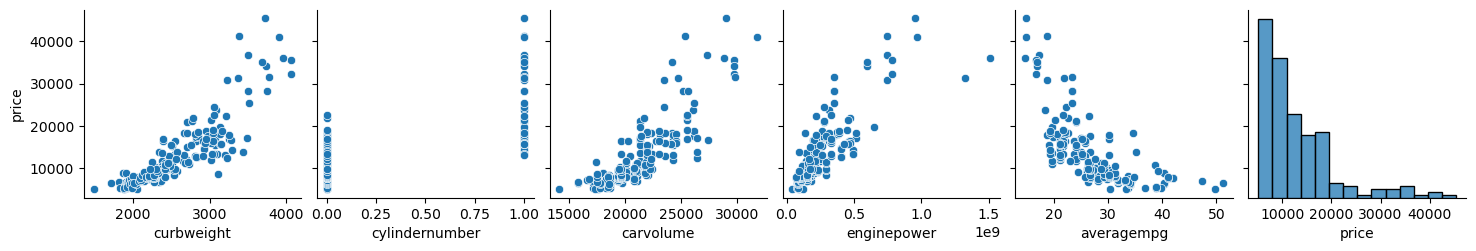

In [49]:
sns.pairplot(data.drop("car_ID").to_pandas(),y_vars="price")

<Axes: >

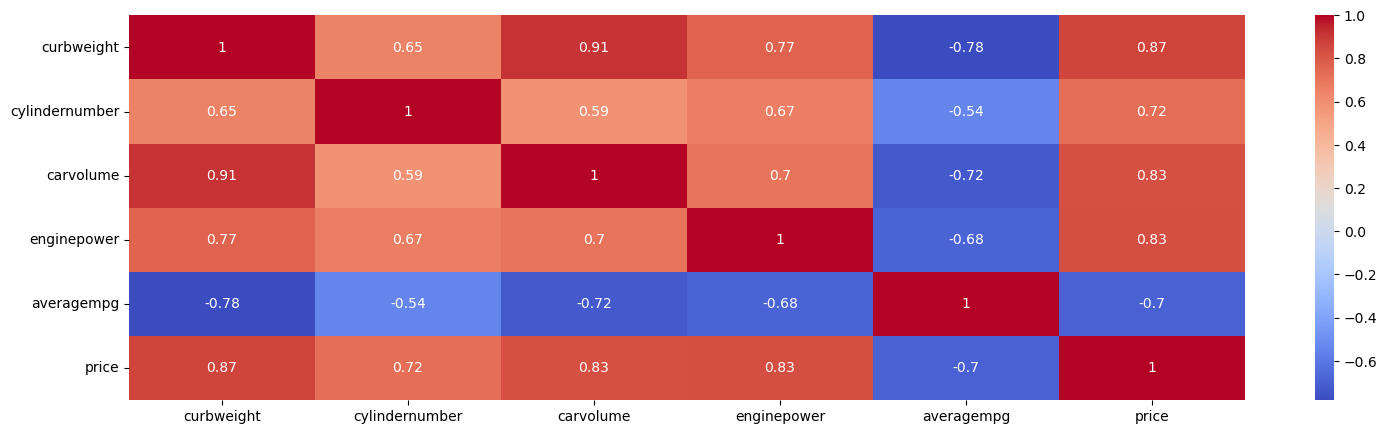

In [50]:
plt.figure(figsize=(18,5))
sns.heatmap(data.drop("car_ID").to_pandas().corr(),annot=True,cmap='coolwarm')

car volume is highly correlated with curbweight

In [51]:
data=data.drop("curbweight")

# Analysing the residuals

Test Scores: [0.82864083 0.82657579 0.55113939]
Training Scores: [0.82478349 0.83163915 0.86001576]
Mean Test Score: 0.7354520057396813
Standard Deviation of Test Scores: 0.1303314262075218
Mean absolute Error: 2422.455293324572
R-squared: 0.8051047870786134


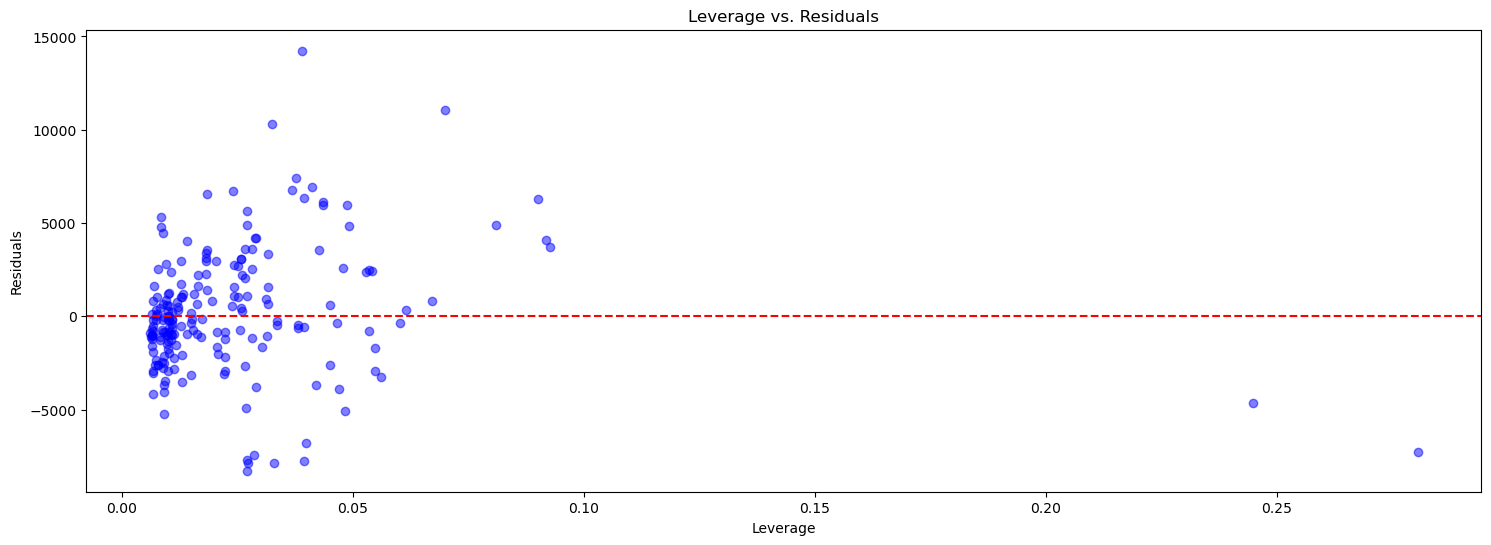

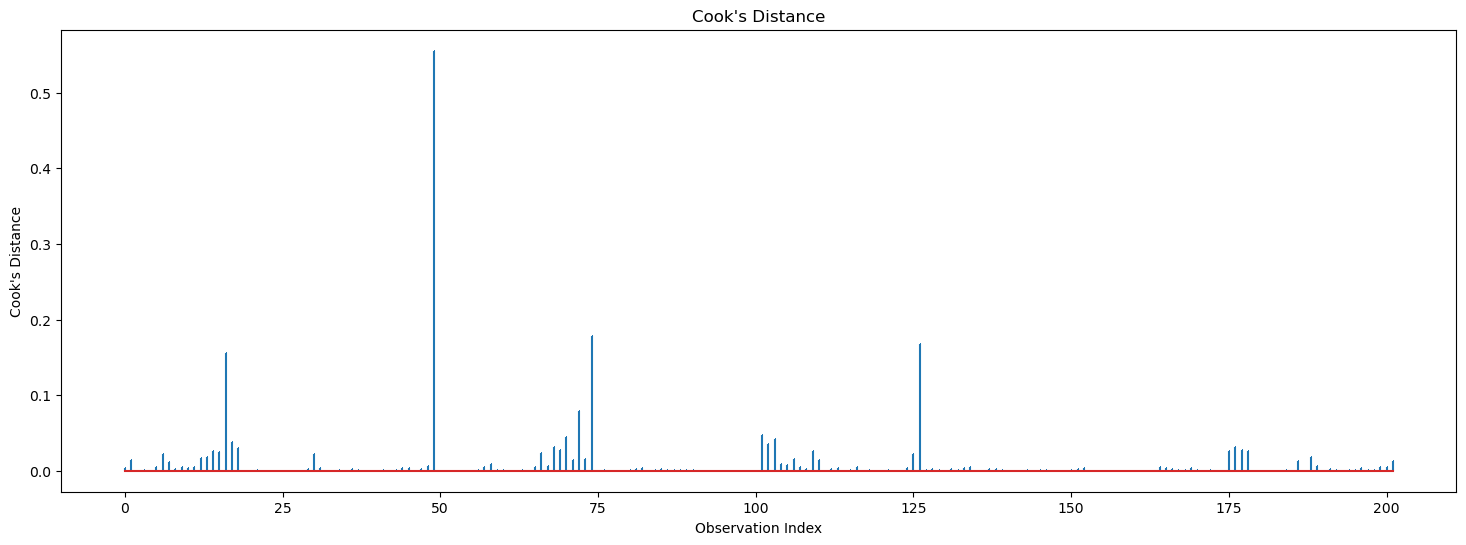

Influential points: [  6  14  15  16  17  18  30  49  66  68  69  70  72  74 101 102 103 109
 125 126 175 176 177 178]


In [52]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split,cross_val_predict,cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,r2_score
X=data.drop('price',"car_ID").to_pandas()
y=data['price'].to_pandas()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5, random_state=0)

# Initialize and fit the Linear Regression model
lr = LinearRegression()
from sklearn.model_selection import KFold
kf=KFold(n_splits=3)
# Cross-validation
cv_results = cross_validate(lr, X, y, cv=kf, scoring='r2', return_train_score=True)
print(f'Test Scores: {cv_results["test_score"]}')
print(f'Training Scores: {cv_results["train_score"]}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

# Predictions
predictions = cross_val_predict(lr, X, y, cv=kf)
residuals = y - predictions
mse = mean_absolute_error(y, predictions)
r2 = r2_score(y, predictions)

print(f'Mean absolute Error: {mse}')
print(f'R-squared: {r2}')

# Compute leverage, Cook's distance using statsmodels
X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm).fit()
influence = model.get_influence()

# Leverage values
leverage = influence.hat_matrix_diag
# Cook's distance
cooks_d = influence.cooks_distance[0]

# Convert to DataFrame for better visualization
influence_df = pd.DataFrame({
    'Leverage': leverage,
    'Cooks Distance': cooks_d,
    'Residuals': residuals
})

# Plotting leverage vs. residuals
plt.figure(figsize=(18,6))
plt.scatter(leverage, residuals, alpha=0.5, color='blue')
plt.axhline(y=0,color='red', linestyle='--')
plt.xlabel('Leverage')
plt.ylabel('Residuals')
plt.title('Leverage vs. Residuals')
plt.show()

# Plotting Cook's distance
plt.figure(figsize=(18,6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.xlabel('Observation Index')
plt.ylabel('Cook\'s Distance')
plt.title('Cook\'s Distance')
plt.show()

# Identify influential points
influential_points = np.where(cooks_d > 4 / len(y))[0]
print(f'Influential points: {influential_points}')

In [53]:
data[influential_points]

car_ID,cylindernumber,carvolume,enginepower,averagempg,price
i64,i64,f64,f64,f64,f64
7,1,26134.271526,2.624732e8,21.7,17710.0
15,1,23494.871634,2.7915547e8,22.25,24565.0
16,1,23494.871634,7.43566824e8,18.7,30760.0
17,1,25362.356983,7.43566824e8,18.7,41315.0
18,1,27289.573712,7.43566824e8,17.25,36880.0
…,…,…,…,…,…
130,1,24752.198495,1.3245e9,21.95,31400.5
179,1,24583.106827,4.68137124e8,21.8,16558.0
180,1,24583.106827,4.68137124e8,21.25,15998.0


c:\Users\chavv\anaconda\envs\eda\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


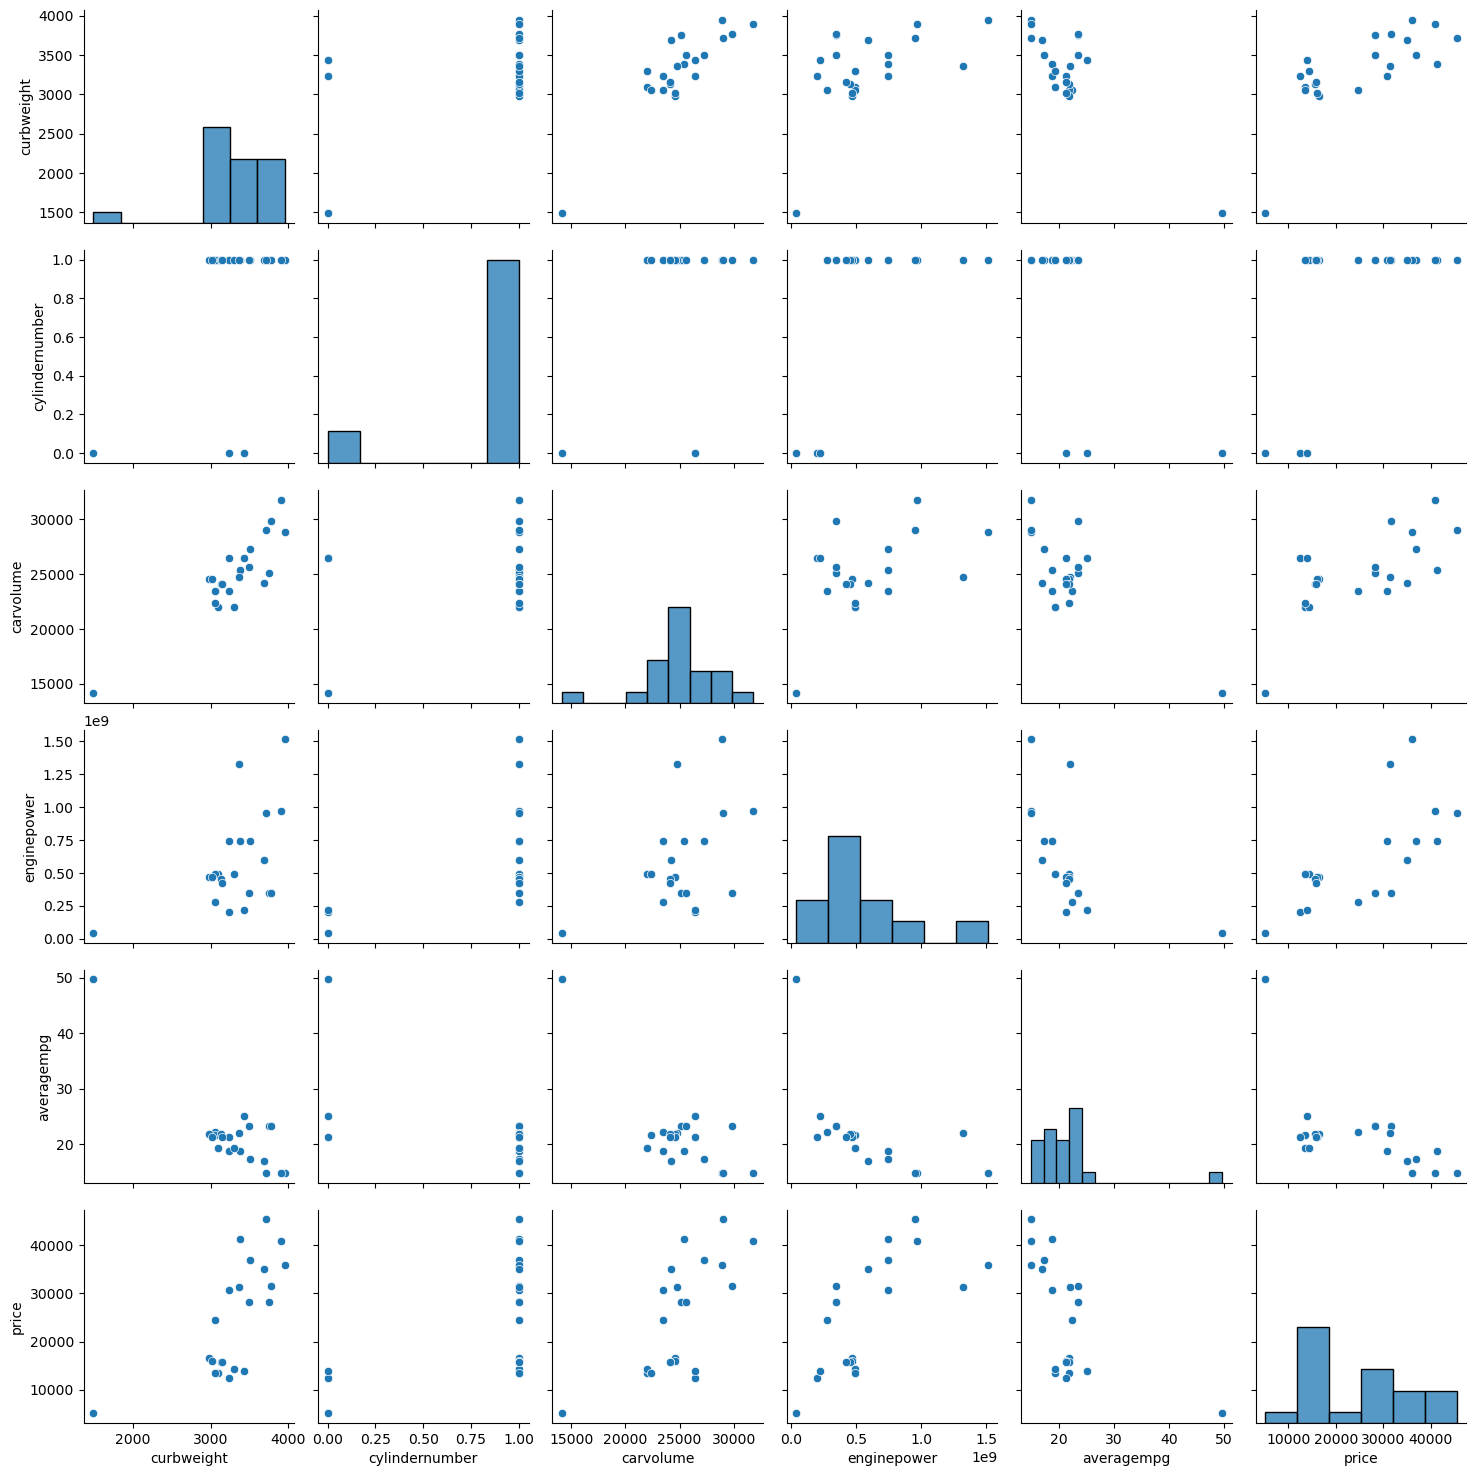

In [36]:
sns.pairplot(data.with_row_index().filter(pl.col("index").is_in(influential_points)).drop("car_ID","index").to_pandas())

Having domain knowledge may analyze these points as true or false entires

# Removing inflential points

In [54]:
data.with_row_index().filter(pl.col("index").is_in(influential_points))

index,car_ID,cylindernumber,carvolume,enginepower,averagempg,price
u32,i64,i64,f64,f64,f64,f64
6,7,1,26134.271526,2.624732e8,21.7,17710.0
14,15,1,23494.871634,2.7915547e8,22.25,24565.0
15,16,1,23494.871634,7.43566824e8,18.7,30760.0
16,17,1,25362.356983,7.43566824e8,18.7,41315.0
17,18,1,27289.573712,7.43566824e8,17.25,36880.0
…,…,…,…,…,…,…
126,130,1,24752.198495,1.3245e9,21.95,31400.5
175,179,1,24583.106827,4.68137124e8,21.8,16558.0
176,180,1,24583.106827,4.68137124e8,21.25,15998.0


In [55]:
data=data.with_row_index().filter(~pl.col("index").is_in(influential_points))
data.write_csv("../Day5_regularization/errorAnalysed.csv")

Test Scores: [0.8746743  0.86044987 0.81655101]
Training Scores: [0.86215504 0.86785614 0.88493784]
Mean Test Score: 0.8505583951040294
Standard Deviation of Test Scores: 0.024738097010698616
Mean absolute Error: 1767.812507580145
R-squared: 0.8721157580002903


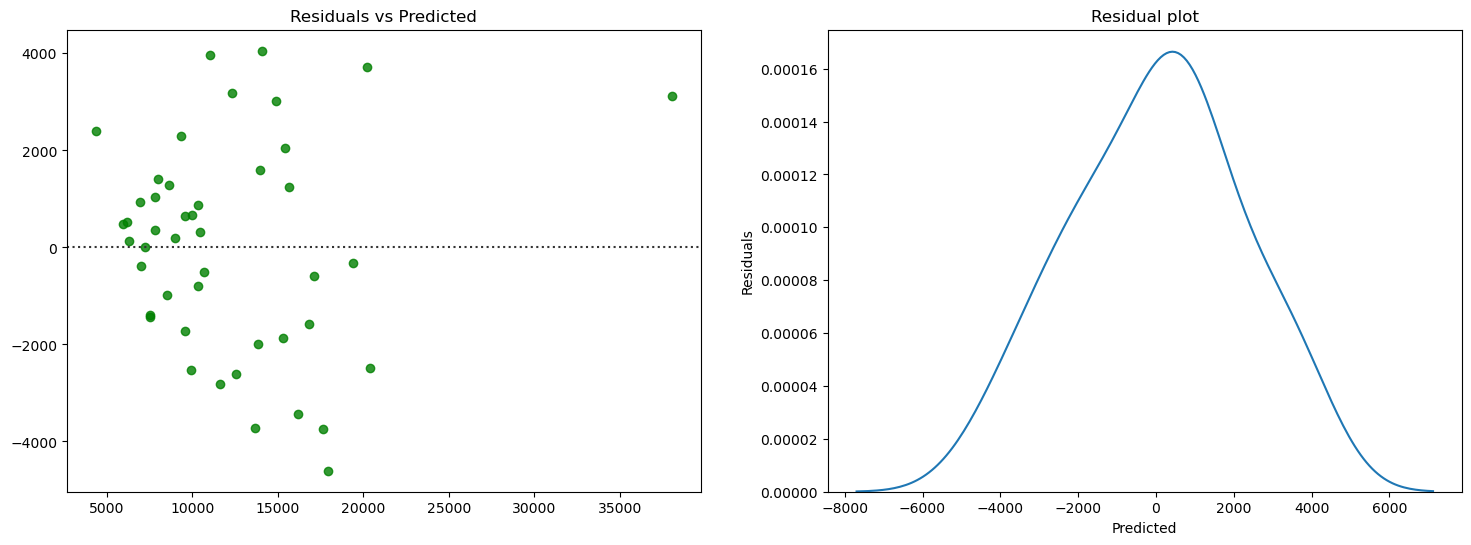

In [56]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
X_train, X_test, y_train, y_test = train_test_split(data.drop("price","car_ID"),data["price"],test_size=0.25,random_state=0)
lr=LinearRegression()

kf=KFold(n_splits=3)
cv_results = cross_validate(lr, X_train,y_train, cv=kf, scoring='r2', return_train_score=True)
print(f'Test Scores: {cv_results["test_score"]}')
print(f'Training Scores: {cv_results["train_score"]}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error,r2_score

predictions = cross_val_predict(lr, X_test, y_test, cv=5)
residuals = y_test - predictions
mse = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean absolute Error: {mse}')
print(f'R-squared: {r2}')

fig,[ax1,ax2] = plt.subplots(ncols=2,figsize=(18,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(residuals,ax=ax2)
ax2.set_title("Residual plot")
plt.show()

In [57]:
n,p = X_test.shape

adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'R-squared: {r2}')
print(f'Adjusted R-squared: {adjusted_r2}')

R-squared: 0.8721157580002903
Adjusted R-squared: 0.8557203423593018


### R2 score increased from 81 to 87 on holdout set and mean_absolute_error descreased from 2628 to 1767

# Residuals are more normalized. and residual range decreased from -10k to 8K to -5k to 5k

But the mean of test score on cross validation increased from 84 to 85